In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

import keras
from keras import layers
from keras import regularizers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.utils.np_utils import to_categorical  

from constants import img_size, train_data_dir, dev_data_dir, num_class, batch_size, epochs

Using TensorFlow backend.


## Generator

In [2]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[1., 1.5],
    shear_range=40,
    zoom_range=0.5,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    channel_shift_range=1.
)

dev_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:650: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [3]:
def get_generator(generator, data_dir):
    return generator.flow_from_directory(
        data_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=0,
        save_to_dir='./data/augmentation_visualization'
    )

In [4]:
train_generator = get_generator(train_datagen, train_data_dir)
dev_generator = get_generator(dev_datagen, dev_data_dir)

Found 9144 images belonging to 120 classes.
Found 1078 images belonging to 120 classes.


In [5]:
batch = next(train_generator)[0]

/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:817: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


## Callbacks

In [6]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')
            
checkpoint = keras.callbacks.ModelCheckpoint(
    './model_2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=True, 
    mode='auto', 
    period=1,
)

## Model

In [8]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling='avg')
#base_model = Model(inputs=vgg16.inputs, outputs=vgg16.get_layer('block5_pool').output)
base_model = vgg16

X = base_model.output
#X = Flatten()(X)
#X = Dropout(0.2)(X)
X = Dense(2048, activation='relu')(X)
#X = Dropout(0.2)(X)
X = Dense(1024, activation='relu')(X)
#X = Dropout(0.2)(X)
outputs = Dense(
    num_class, 
    activation='softmax', 
    #activity_regularizer=regularizers.l2(10.)
)(X)

model = Model(inputs=base_model.inputs, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer=tf.train.AdamOptimizer(0.00001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Training

In [9]:
plot_losses = PlotLosses()

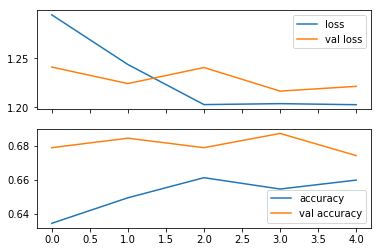

Epoch 1
-----------------------
- Loss: 1.29405562178
- Accuracy: 0.634623797025
- Validation loss: 1.24101460184
- Validation accuracy: 0.679035250464
 
Epoch 2
-----------------------
- Loss: 1.2436242198
- Accuracy: 0.649606299213
- Validation loss: 1.22426468312
- Validation accuracy: 0.684601113283
 
Epoch 3
-----------------------
- Loss: 1.20292234455
- Accuracy: 0.661417322835
- Validation loss: 1.24058413308
- Validation accuracy: 0.679035250574
 
Epoch 4
-----------------------
- Loss: 1.20389187034
- Accuracy: 0.654746281715
- Validation loss: 1.21661986769
- Validation accuracy: 0.687384044637
 
Epoch 5
-----------------------
- Loss: 1.20281602117
- Accuracy: 0.659995625547
- Validation loss: 1.22144049115
- Validation accuracy: 0.67439703165
 


In [10]:
model.load_weights('./model_2/weights.02-1.25.hdf5')

model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=dev_generator,
    validation_steps=len(dev_generator),
    callbacks=[plot_losses, checkpoint], 
)

## Predictions

In [9]:
real_classes = dev_generator.classes
real_classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [10]:
model.load_weights('./model_2/weights.01-1.15.hdf5')

In [11]:
dev_generator.reset()

In [12]:
predictions = model.predict_generator(
    dev_generator,
    steps=len(dev_generator),
    verbose=1
)

135/135 [==============================] - 553s 4s/step


In [13]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([  0,  42,  70, ..., 119, 111,   6])

In [14]:
predictions_df = pd.DataFrame({
    "filenames": dev_generator.filenames,
    "real": real_classes,
    "predictions": predicted_classes,
})

In [15]:
wrong_answers = predictions_df[predictions_df['real'] != predictions_df['predictions']]
wrong_answers.shape

(307, 3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


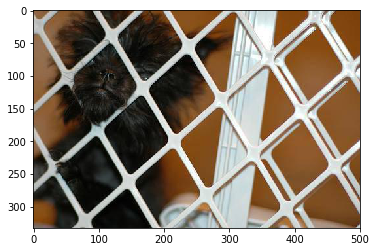

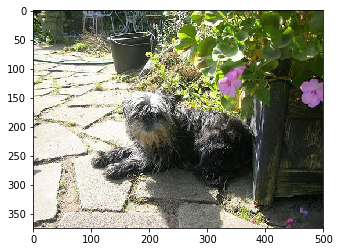

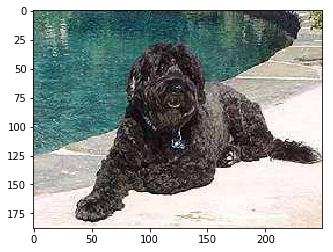

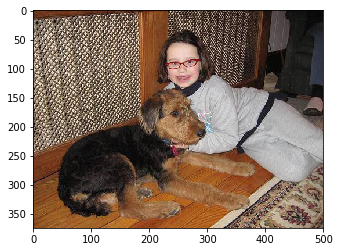

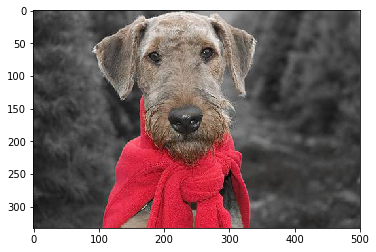

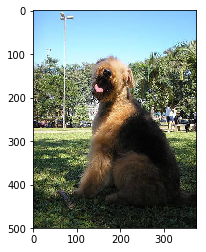

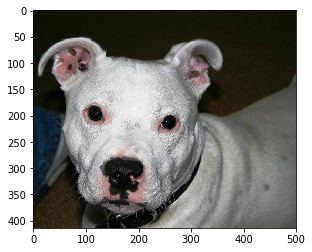

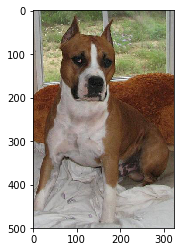

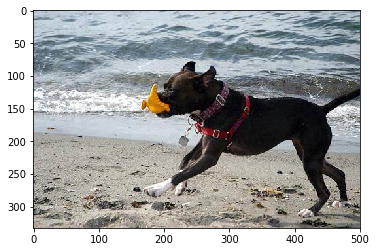

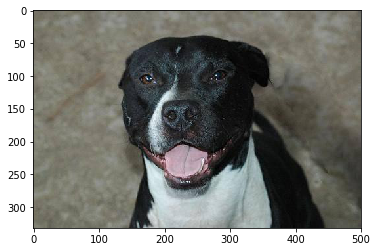

In [13]:
for filename in wrong_answers['filenames'][0:10]:
    image = np.array(ndimage.imread('./data/dev_dataset/' + filename, flatten=False))
    plt.figure()
    plt.imshow(image)